In [67]:
# import libraries
import pandas as pd
import numpy as np
import torch
import os
from tqdm import tqdm
import torchvision
import json
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# code to unzip file
# import zipfile

# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/CV datasets/hateful_memes.zip", 'r')
# zip_ref.extractall("/content/drive/MyDrive/CV datasets/meme_images")
# zip_ref.close()

In [3]:
# put5 model onto the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# read data from jsonl files
train_data = []
val_data = []

for line in  open("/content/drive/MyDrive/CV datasets/DL Assignment/A4/hateful_memes/train.jsonl"):
  train_data.append(json.loads(line)) 


for line in  open("/content/drive/MyDrive/CV datasets/DL Assignment/A4/hateful_memes/dev_seen.jsonl"):
  val_data.append(json.loads(line)) 

In [7]:
test_data = []

for line in  open("/content/drive/MyDrive/CV datasets/DL Assignment/A4/hateful_memes/test_seen.jsonl"):
  test_data.append(json.loads(line)) 

In [ ]:
# convert train json data to dataframe
from sklearn.model_selection import train_test_split

train_df = pd.DataFrame(train_data)
img_path = train_df.img
labels = train_df.label
print(type(labels[0]))
path_1, path_2, labels_1, labels_2 = train_test_split(img_path, labels, test_size=0.3, stratify=labels, random_state=23)
train_df = pd.DataFrame(np.column_stack([path_1, labels_1]), columns=['img', 'label'])
print(train_df.shape)
train_df.head()

<class 'numpy.int64'>
(5950, 2)


,img,label
0,img/93168.png,0
1,img/79638.png,0
2,img/94178.png,0
3,img/26417.png,0
4,img/41562.png,0


In [ ]:
# convert validation json data to dataframe
val_df = pd.DataFrame(val_data)
val_df = val_df.drop(columns=['id', 'text'])
print(val_df.shape)
val_df.head()

(500, 2)


,img,label
0,img/08291.png,1
1,img/46971.png,1
2,img/03745.png,1
3,img/83745.png,1
4,img/80243.png,1


In [12]:
# convert test json data to dataframe
test_df = pd.DataFrame(test_data)
test_df = test_df.drop(columns=['id', 'text'])
print(test_df.shape)
test_df.head()

(1000, 2)


,img,label
0,img/16395.png,1
1,img/37405.png,1
2,img/94180.png,1
3,img/54321.png,1
4,img/97015.png,1


In [8]:
# function to get image from path
def get_image(path):
  try  :
    img = torchvision.io.read_image("/content/drive/MyDrive/CV datasets/DL Assignment/A4/hateful_memes/{}".format(path))
    return img
  except:
    return "missing"

In [9]:
# get the tensor data from images
def get_data(df):
   df['img_features'] = df['img'].apply(get_image)
   df = df[df.img_features != "missing"]
   df['data_shape'] = df['img_features'].apply(lambda x: x.shape[0])
   df = df[df.data_shape != 4]
   df = df.reset_index()
   print(df.shape)
   X, y = df['img_features'].values, df['label']
   return X, y

In [ ]:
# get features and labels from train images
X_val, y_val = get_data(val_df)

(260, 5)


In [ ]:
# get features and labels from train images
X_test, y_test = get_data(test_df)

(530, 5)


In [ ]:
# get features and labels from train images
X_train, y_train = get_data(train_df)

(3388, 5)


In [10]:
# custom dataset class
class MemeDataset(Dataset):
  def __init__(self, x, y, transform):
    self.X = x
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    image = self.X[index]
    label = self.y[index]

    if self.transform:
      image = image.to(torch.float)
      image = self.transform(image) / 255
    return image, label


# create transformations
transform1 = transforms.Compose([transforms.Resize((224, 244)), transforms.RandomRotation(degrees=45)])
transform2 = transforms.Compose([transforms.Resize((224, 244))])

In [ ]:
# create dataset
train_dataset = MemeDataset(X_train, y_train, transform1)
validation_dataset = MemeDataset(X_val, y_val, transform2)
test_dataset = MemeDataset(X_test, y_test, transform2)

In [ ]:
# create custom dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=40, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=40, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=40, shuffle=False)

In [ ]:
# load data from dataloaders
# train_dataloader = torch.load("/content/drive/MyDrive/CV datasets/DL Assignment/A4/hateful_memes/train_dataloader.pt")
# validation_dataloader = torch.load("/content/drive/MyDrive/CV datasets/DL Assignment/A4/hateful_memes/validation_dataloader.pt")
# test_dataloader = torch.load("/content/drive/MyDrive/CV datasets/DL Assignment/A4/hateful_memes/test_dataloader.pt")

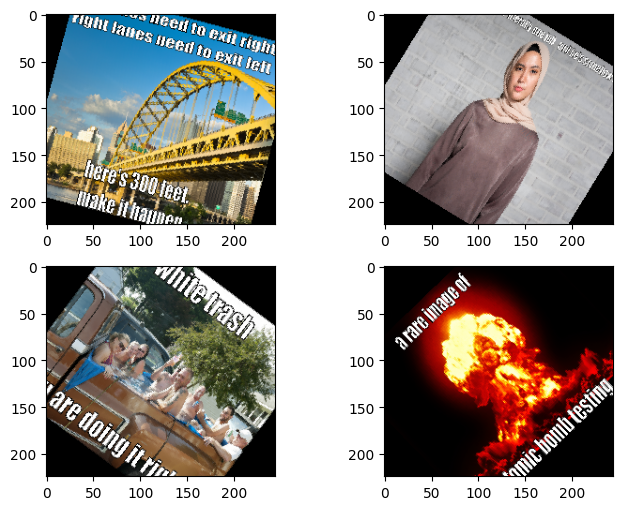

In [ ]:
# plot some images
plt.figure(figsize=(8, 6))
k = 0
for i, jaccard_score in train_dataset:
  if k > 3:
    break
  plt.subplot(2, 2, k+1)
  plt.imshow(i.numpy().transpose(1, 2, 0))
  k += 1

## Load the model 

In [ ]:
# load the model
model = models.vgg16(pretrained=True)
num_features = model.classifier[6].in_features
model.fc1 = nn.Linear(num_features, 2)
# model.fc2 = nn.Linear(50, 2)
# nn.init.kaiming_uniform_(model.fc1.weight)
# nn.init.kaiming_uniform_(model.fc2.weight)

model.to(device)
class_weights = torch.Tensor([0.5, 1]).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.3)
num_epochs = 8
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# for loading dataloaders
import __main__
setattr(__main__, "Net", MemeDataset)

In [ ]:
# load dataloaders
train_dataloader = torch.load("/content/drive/MyDrive/CV datasets/DL Assignment/A4/hateful_memes/train_dataloader.pt")
validation_dataloader = torch.load("/content/drive/MyDrive/CV datasets/DL Assignment/A4/hateful_memes/validation_dataloader.pt")
test_dataloader = torch.load("/content/drive/MyDrive/CV datasets/DL Assignment/A4/hateful_memes/test_dataloader.pt")

## Model Training 

In [ ]:
# training loop
total_train_loss = []
total_val_loss = []
train_accuracy_list = []
val_accuracy_list = []


for x in range(num_epochs):
  batch_train_loss = 0
  batch_val_loss = 0
  num_batches = 0
  n_correct = 0
  n_samples = 0

  for i, (images, labels)  in enumerate(train_dataloader):
    # print(labels)
    images = images.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    # forward pass
    predicted = model(images)
    loss = criterion(predicted, labels)
    
    # backward pass
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # compute matched samples
    _, predicted = torch.max(predicted, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    # add batch loss
    batch_train_loss += loss.item()
    num_batches += 1

  print("train loss :", loss.item())
  batch_train_loss /= num_batches
  total_train_loss.append(batch_train_loss)

  # add accuracy to list
  acc = 100 * n_correct / n_samples
  train_accuracy_list.append(acc)

  # validation accuracy
  with torch.no_grad():
    n_correct = 0
    n_samples = 0
    count = 0

    for i, (images, labels) in enumerate(validation_dataloader):
      images = images.to(device)
      labels = labels.type(torch.LongTensor).to(device)
      
      output = model(images)
      loss = criterion(output, labels)
      
      batch_val_loss += loss.item()
      count += 1

      _, predicted = torch.max(output, 1)
      n_samples += labels.size(0)
      n_correct += (predicted == labels).sum().item()
    
    acc = 100 * n_correct / n_samples
    batch_val_loss /= count
    total_val_loss.append(batch_val_loss) 
    val_accuracy_list.append(acc)
    print("val loss :", batch_val_loss)
    print()
  
  
print('Finished Training')

train loss : 0.9844103455543518
val loss : 0.7506195902824402

train loss : 0.7310934066772461
val loss : 0.7979457463536944

train loss : 0.7300434112548828
val loss : 0.7043872475624084

train loss : 0.7038423418998718
val loss : 0.8216828874179295

train loss : 0.6740135550498962
val loss : 0.7250900268554688

train loss : 0.633453905582428
val loss : 0.8956033842904227

train loss : 0.7868438959121704
val loss : 0.7602364250591823

train loss : 0.6889912486076355
val loss : 0.7144824947629657

Finished Training


In [ ]:
# # save the model
torch.save(model, "/content/drive/MyDrive/CV datasets/DL Assignment/A4/hateful_memes/vgg_model.pth")

In [6]:
# # load the model
loaded_model = torch.load("/content/drive/MyDrive/CV datasets/DL Assignment/A4/hateful_memes/vgg_model.pth")
print("model loaded")

model loaded


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model Testing

In [ ]:
from sklearn.metrics import classification_report

# testing loop
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  labels_list = []
  predicted_list = []

  for i, (images, labels) in enumerate(test_dataloader):
    images = images.to(device)
    labels = labels.to(device)
    
    output = loaded_model(images)
    _, predicted = torch.max(output, 1)
    
    labels_list.extend(labels.data.detach().cpu().numpy().tolist())
    predicted_list.extend(predicted.detach().cpu().numpy().tolist())

  report = classification_report(labels_list, predicted_list)
  print(report)

              precision    recall  f1-score   support

           0       0.55      0.45      0.49       288
           1       0.46      0.56      0.51       242

    accuracy                           0.50       530
   macro avg       0.50      0.50      0.50       530
weighted avg       0.51      0.50      0.50       530



In [ ]:
# # plot the loss graph
plt.plot(list(range(1, 9)), total_train_loss, label='train loss')
plt.plot(list(range(1, 9)), total_val_loss, label='val loss')
plt.xlabel("No. of epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

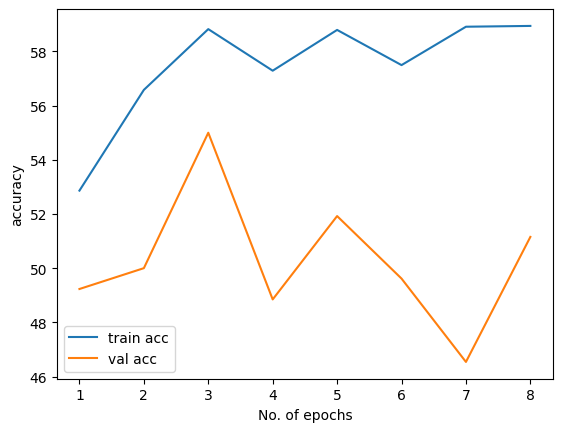

In [ ]:
# plot the accuracy
plt.plot(list(range(1, 9)), train_accuracy_list, label='train acc')
plt.plot(list(range(1, 9)), val_accuracy_list, label='val acc')
plt.xlabel("No. of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# Code for plotting TSNE plot

In [13]:
# take 50 test smaples for each labels for TSNE plot
hate = []
non_hate = []
t1 = 50
t2 = 50

for i, label in enumerate(test_df.label):
  if label == 1 and t1 != 0:
    t1 -= 1
    hate.append((test_df.iloc[i, 0], label))
  elif label == 0 and t2 != 0:
    t2 -= 1
    non_hate.append((test_df.iloc[i, 0], label))
  elif t1 == 0 and t2 == 0:
    break


hate_df = pd.DataFrame(hate, columns=['img', 'label'])
display(hate_df.head())
nonhate_df = pd.DataFrame(non_hate, columns=['img', 'label'])
nonhate_df.head()

,img,label
0,img/16395.png,1
1,img/37405.png,1
2,img/94180.png,1
3,img/54321.png,1
4,img/97015.png,1


,img,label
0,img/70691.png,0
1,img/89263.png,0
2,img/52971.png,0
3,img/24973.png,0
4,img/02356.png,0


In [73]:
# save files
hate_df.to_csv("hate_df.csv", index=False)
nonhate_df.to_csv("nonhate_df.csv", index=False)

In [14]:
# get the features and labels of hate and non hate image
hate_X, hate_y = get_data(hate_df)
nonhate_X, nonhate_y = get_data(nonhate_df)

(50, 5)
(50, 5)


In [42]:
# create dataset and dataloader for hate data
hate_test_dataset = MemeDataset(hate_X, hate_y, transform1)
nonhate_test_dataset = MemeDataset(nonhate_X, nonhate_y, transform1)

hate_dataloader = DataLoader(hate_test_dataset, batch_size=50)
nonhate_dataloader = DataLoader(nonhate_test_dataset, batch_size=50)

In [92]:
# extract the feature of vgg16 models
vgg_features = torch.nn.Sequential(*list(loaded_model.children())[:-2])
vgg_features

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [113]:
# extract hate feature from vgg16
for images, labels in hate_dataloader:
  images = images.to(device)
  labels =  labels.to(device)
  print(vgg_features(images).cpu().detach().numpy().shape)
  hate_features = vgg_features(images).cpu().detach().numpy().reshape(50, -1)
  hate_labels = labels.cpu().numpy().flatten()

print(hate_features.shape)
print(hate_labels.shape)


# extract nonhate feature from vgg16
for images, labels in nonhate_dataloader:
  images = images.to(device)
  labels =  labels.to(device)

  nonhate_features = vgg_features(images).cpu().detach().numpy().reshape(50, -1)
  nonhate_labels = labels.cpu().numpy().flatten()

print(nonhate_features.shape)
print(nonhate_labels.shape)

(50, 512, 7, 7)
(50, 25088)
(50,)
(50, 25088)
(50,)


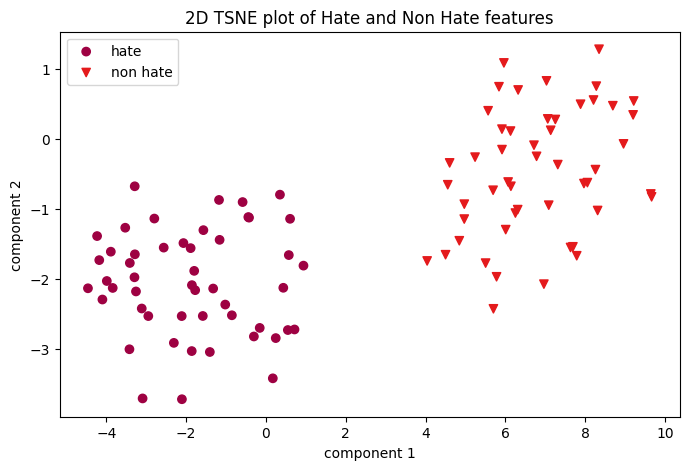

In [140]:
# TSNE plot of nonhate features
plt.figure(figsize=(8, 5))
hate_embeddings = TSNE(n_components=2).fit_transform(hate_features)
nonhate_embeddings = TSNE(n_components=2).fit_transform(nonhate_features)
plt.scatter(hate_embeddings[:, 0], hate_embeddings[:, 1], c=hate_labels, marker='o', cmap='Spectral', label='hate')
plt.scatter(nonhate_embeddings[:, 0], nonhate_embeddings[:, 1], c=nonhate_labels, marker='v', cmap='Set1', label='non hate')
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title("2D TSNE plot of Hate and Non Hate features")
plt.legend()
plt.show()